In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
import snntorch.functional as SF
from snntorch import backprop
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np

/var/folders/_5/77pml32s01b27rqdn8pjj4xh0000gp/T/ipykernel_62754/2010404222.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [2]:
import sys
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
sys.path.append(os.path.relpath("robot_trajectories.py"))
from robot_trajectories import RobotTrajectories # import RobotTrajectories Functions
from warnings import warn
from snntorch.surrogate import atan
import torch
import torch.nn as nn

In [3]:
def raster(data, ax, **kwargs):
  if len(data.shape) == 1:
    return ax.scatter(*jnp.where(data.unsqueeze(1)), **kwargs)
  return ax.scatter(*jnp.where(data), **kwargs)

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(spk_in.size(0), -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(spk_in.size(0), -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [4]:
# Spiking Neuron & LIF class
__all__ = [
    "SpikingNeuron",
    "LIF",
]

dtype = torch.float


class SpikingNeuron1(nn.Module):
    """Parent class for spiking neuron models."""

    instances = []
    """Each :mod:`snntorch.SpikingNeuron` neuron
    (e.g., :mod:`snntorch.Synaptic`) will populate the
    :mod:`snntorch.SpikingNeuron.instances` list with a new entry.
    The list is used to initialize and clear neuron states when the
    argument `init_hidden=True`."""

    reset_dict = {
        "subtract": 0,
        "zero": 1,
        "none": 2,
    }

    def __init__(
        self,
        threshold=1.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_threshold=False,
        reset_mechanism="subtract",
        state_quant=False,
        output=False,
        graded_spikes_factor=1.0,
        learn_graded_spikes_factor=False,
    ):
        super().__init__()

        SpikingNeuron1.instances.append(self)

        if surrogate_disable:
            self.spike_grad = self._surrogate_bypass
        elif spike_grad == None:
            self.spike_grad = atan()
        else:
            self.spike_grad = spike_grad

        self.init_hidden = init_hidden
        self.inhibition = inhibition
        self.output = output
        self.surrogate_disable = surrogate_disable

        self._snn_cases(reset_mechanism, inhibition)
        self._snn_register_buffer(
            threshold=threshold,
            learn_threshold=learn_threshold,
            reset_mechanism=reset_mechanism,
            graded_spikes_factor=graded_spikes_factor,
            learn_graded_spikes_factor=learn_graded_spikes_factor,
        )
        self._reset_mechanism = reset_mechanism

        self.state_quant = state_quant

    def fire(self, mem):
        """Generates spike if mem > threshold.
        Returns spk."""

        if self.state_quant:
            mem = self.state_quant(mem)
        
        mem_shift = mem - self.threshold
        spk = self.spike_grad(mem_shift)

        spk = spk * self.graded_spikes_factor

        return spk

    def fire_inhibition(self, batch_size, mem):
        """Generates spike if mem > threshold, only for the largest membrane.
        All others neurons will be inhibited for that time step.
        Returns spk."""
        mem_shift = mem - self.threshold
        print("memshift shape",mem_shift.shape)
        index = torch.argmax(mem_shift, dim=1)
        spk_tmp = self.spike_grad(mem_shift)

        mask_spk1 = torch.zeros_like(spk_tmp)
        mask_spk1[torch.arange(batch_size), index] = 1
        spk = spk_tmp * mask_spk1
        # reset = spk.clone().detach()

        return spk

    def mem_reset(self, mem):
        """Generates detached reset signal if mem > threshold.
        Returns reset."""
        mem_shift = mem - self.threshold
        reset = self.spike_grad(mem_shift).clone().detach()

        return reset

    def _snn_cases(self, reset_mechanism, inhibition):
        self._reset_cases(reset_mechanism)

        if inhibition:
            warn(
                "Inhibition is an unstable feature that has only been tested "
                "for dense (fully-connected) layers. Use with caution!",
                UserWarning,
            )

    def _reset_cases(self, reset_mechanism):
        if (
            reset_mechanism != "subtract"
            and reset_mechanism != "zero"
            and reset_mechanism != "none"
        ):
            raise ValueError(
                "reset_mechanism must be set to either 'subtract', "
                "'zero', or 'none'."
            )

    def _snn_register_buffer(
        self,
        threshold,
        learn_threshold,
        reset_mechanism,
        graded_spikes_factor,
        learn_graded_spikes_factor,
    ):
        """Set variables as learnable parameters else register them in the
        buffer."""

        self._threshold_buffer(threshold, learn_threshold)
        self._graded_spikes_buffer(
            graded_spikes_factor, learn_graded_spikes_factor
        )

        # reset buffer
        try:
            # if reset_mechanism_val is loaded from .pt, override
            # reset_mechanism
            if torch.is_tensor(self.reset_mechanism_val):
                self.reset_mechanism = list(SpikingNeuron.reset_dict)[
                    self.reset_mechanism_val
                ]
        except AttributeError:
            # reset_mechanism_val has not yet been created, create it
            self._reset_mechanism_buffer(reset_mechanism)

    def _graded_spikes_buffer(
        self, graded_spikes_factor, learn_graded_spikes_factor
    ):
        if not isinstance(graded_spikes_factor, torch.Tensor):
            graded_spikes_factor = torch.as_tensor(graded_spikes_factor)
        if learn_graded_spikes_factor:
            self.graded_spikes_factor = nn.Parameter(graded_spikes_factor)
        else:
            self.register_buffer("graded_spikes_factor", graded_spikes_factor)

    def _threshold_buffer(self, threshold, learn_threshold):
        if not isinstance(threshold, torch.Tensor):
            threshold = torch.as_tensor(threshold)
        if learn_threshold:
            self.threshold = nn.Parameter(threshold)
        else:
            self.register_buffer("threshold", threshold)

    def _reset_mechanism_buffer(self, reset_mechanism):
        """Assign mapping to each reset mechanism state.
        Must be of type tensor to store in register buffer. See reset_dict
        for mapping."""
        reset_mechanism_val = torch.as_tensor(
            SpikingNeuron1.reset_dict[reset_mechanism]
        )
        self.register_buffer("reset_mechanism_val", reset_mechanism_val)

    def _V_register_buffer(self, V, learn_V):
        if not isinstance(V, torch.Tensor):
            V = torch.as_tensor(V)
        if learn_V:
            self.V = nn.Parameter(V)
        else:
            self.register_buffer("V", V)

    @property
    def reset_mechanism(self):
        """If reset_mechanism is modified, reset_mechanism_val is triggered
        to update.
        0: subtract, 1: zero, 2: none."""
        return self._reset_mechanism

    @reset_mechanism.setter
    def reset_mechanism(self, new_reset_mechanism):
        self._reset_cases(new_reset_mechanism)
        self.reset_mechanism_val = torch.as_tensor(
            SpikingNeuron1.reset_dict[new_reset_mechanism]
        )
        self._reset_mechanism = new_reset_mechanism

    @classmethod
    def init(cls):
        """Removes all items from :mod:`snntorch.SpikingNeuron.instances`
        when called."""
        cls.instances = []

    @staticmethod
    def detach(*args):
        """Used to detach input arguments from the current graph.
        Intended for use in truncated backpropagation through time where
        hidden state variables are global variables."""
        for state in args:
            state.detach_()

    @staticmethod
    def zeros(*args):
        """Used to clear hidden state variables to zero.
        Intended for use where hidden state variables are global variables."""
        for state in args:
            state = torch.zeros_like(state)

    @staticmethod
    def _surrogate_bypass(input_):
        return (input_ > 0).float()


class LIF1(SpikingNeuron1):
    """Parent class for leaky integrate and fire neuron models."""

    def __init__(
        self,
        beta,
        threshold=1.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        reset_mechanism="subtract",
        state_quant=False,
        output=False,
        graded_spikes_factor=1.0,
        learn_graded_spikes_factor=False,
    ):
        super().__init__(
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
            graded_spikes_factor,
            learn_graded_spikes_factor,
        )

        self._lif_register_buffer(
            beta,
            learn_beta,
        )
        self._reset_mechanism = reset_mechanism

    def _lif_register_buffer(
        self,
        beta,
        learn_beta,
    ):
        """Set variables as learnable parameters else register them in the
        buffer."""
        self._beta_buffer(beta, learn_beta)

    def _beta_buffer(self, beta, learn_beta):
        if not isinstance(beta, torch.Tensor):
            beta = torch.as_tensor(beta)  # TODO: or .tensor() if no copy
        if learn_beta:
            self.beta = nn.Parameter(beta)
        else:
            self.register_buffer("beta", beta)

    def _V_register_buffer(self, V, learn_V):
        if V is not None:
            if not isinstance(V, torch.Tensor):
                V = torch.as_tensor(V)
        if learn_V:
            self.V = nn.Parameter(V)
        else:
            self.register_buffer("V", V)


In [5]:
import torch
import torch.nn as nn
from snntorch import functional
from snntorch import LIF

class RLIF1(LIF):
    def __init__(
        self,
        beta,
        V=1.0,
        all_to_all=True,
        linear_features=None,
        conv2d_channels=None,
        kernel_size=None,
        threshold= -55.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        learn_recurrent=True,  # changed learn_V
        reset_mechanism="zero",
        state_quant=False,
        output=False,
        reset_delay=True,
        refractory_period=2.5,  # in milliseconds
    ):
        super().__init__(
            beta,
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_beta,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
        )

        self.all_to_all = all_to_all
        self.learn_recurrent = learn_recurrent

        # linear params
        self.linear_features = linear_features

        # Conv2d params
        self.kernel_size = kernel_size
        self.conv2d_channels = conv2d_channels

        # catch cases
        self._rleaky_init_cases()

        # initialize recurrent connections
        if self.all_to_all:  # init all-all connections
            self._init_recurrent_net()
        else:  # initialize 1-1 connections
            self._V_register_buffer(V, learn_recurrent)
            self._init_recurrent_one_to_one()

        if not learn_recurrent:
            self._disable_recurrent_grad()

        self._init_mem()

        if self.reset_mechanism_val == 0:  # reset by subtraction
            self.state_function = self._base_sub
        elif self.reset_mechanism_val == 1:  # reset to zero
            self.state_function = self._base_zero
        elif self.reset_mechanism_val == 2:  # no reset, pure integration
            self.state_function = self._base_int

        self.reset_delay = reset_delay

        # Refractory period in timesteps
        self.refractory_period = refractory_period

    def _init_mem(self):
        #initialize spike, membrane, and refractory counter
        spk = torch.zeros(0)
        mem = torch.zeros(0)
        refractory_counter = torch.zeros(0)

        self.register_buffer("spk", spk, False)
        self.register_buffer("mem", mem, False)
        #persistent=False, you are indicating that refractory_counter is an intermediate state that should not be included in the model's state_dic
        self.register_buffer("refractory_counter", refractory_counter, persistent=False)

    def reset_mem(self):
        self.spk = torch.zeros_like(self.spk, device=self.spk.device)
        self.mem = torch.zeros_like(self.mem, device=self.mem.device)
        self.refractory_counter = torch.zeros_like(self.refractory_counter, device=self.refractory_counter.device)
        return self.spk, self.mem

    def init_rleaky(self):
        """Deprecated, use :class:`RLeaky.reset_mem` instead"""
        return self.reset_mem()

    def forward(self, input_, spk=None, mem=None, refractory_counter=None):
        if not spk is None:
            self.spk = spk

        if not mem is None:
            self.mem = mem

        if not refractory_counter is None:
            self.refractory_counter = refractory_counter

        if self.init_hidden and (not mem is None or not spk is None or not refractory_counter is None):
            raise TypeError(
                "When `init_hidden=True`, RLeaky expects 1 input argument."
            )

        if not self.spk.shape == input_.shape:
            self.spk = torch.zeros_like(input_, device=self.spk.device)

        if not self.mem.shape == input_.shape:
            self.mem = torch.zeros_like(input_, device=self.mem.device)

        if not self.refractory_counter.shape == input_.shape:
            self.refractory_counter = torch.zeros_like(input_, device=self.refractory_counter.device)

        # With each forward, decrement the counter
        self.refractory_counter = torch.clamp(self.refractory_counter - 1, min=0)

        # Update the membrane potential
        self.reset = self.mem_reset(self.mem)
        self.mem = self.state_function(input_)

        # set a spike on when refractory period is 0
        refractory_mask = (self.refractory_counter == 0)
        self.spk = self.fire(self.mem) * refractory_mask

        # Update the refractory counter back to 5 where spikes occurred
        self.refractory_counter[self.spk > 0] = self.refractory_period

        if not self.reset_delay:
            do_reset = (
                self.spk / self.graded_spikes_factor - self.reset
            )  # avoid double reset
            if self.reset_mechanism_val == 0:  # reset by subtraction
                self.mem = self.mem - do_reset * self.threshold
            elif self.reset_mechanism_val == 1:  # reset to zero
                self.mem = self.mem - do_reset * self.mem

        if self.output:
            return self.spk, self.mem
        elif self.init_hidden:
            return self.spk
        else:
            return self.spk, self.mem

    def _init_recurrent_net(self):
        if self.all_to_all:
            if self.linear_features:
                self._init_recurrent_linear()
            elif self.kernel_size is not None:
                self._init_recurrent_conv2d()
        else:
            self._init_recurrent_one_to_one()

    def _init_recurrent_linear(self):
        self.recurrent = nn.Linear(self.linear_features, self.linear_features)

    def _init_recurrent_conv2d(self):
        self._init_padding()
        self.recurrent = nn.Conv2d(
            in_channels=self.conv2d_channels,
            out_channels=self.conv2d_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
        )

    def _init_padding(self):
        if type(self.kernel_size) is int:
            self.padding = self.kernel_size // 2, self.kernel_size // 2
        else:
            self.padding = self.kernel_size[0] // 2, self.kernel_size[1] // 2

    def _init_recurrent_one_to_one(self):
        self.recurrent = RecurrentOneToOne(self.V)

    def _disable_recurrent_grad(self):
        for param in self.recurrent.parameters():
            param.requires_grad = False

    def _base_state_function(self, input_):
        base_fn = (
            self.beta.clamp(0, 1) * self.mem
            + input_
            + self.recurrent(self.spk)
        )
        return base_fn

    def _base_sub(self, input_):
        return self._base_state_function(input_) - self.reset * self.threshold

    def _base_zero(self, input_):
        return self._base_state_function(input_) - self.reset * (self.mem + 70)

    def _base_int(self, input_):
        return self._base_state_function(input_)

    def _rleaky_init_cases(self):
        all_to_all_bool = bool(self.all_to_all)
        linear_features_bool = self.linear_features
        conv2d_channels_bool = bool(self.conv2d_channels)
        kernel_size_bool = bool(self.kernel_size)

        if all_to_all_bool:
            if not (linear_features_bool):
                if not (conv2d_channels_bool or kernel_size_bool):
                    raise TypeError(
                        "When `all_to_all=True`, RLeaky requires either"
                        "`linear_features` or (`conv2d_channels` and "
                        "`kernel_size`) to be specified. The "
                        "shape should match the shape of the output spike of "
                        "the layer."
                    )
                elif conv2d_channels_bool ^ kernel_size_bool:
                    raise TypeError(
                        "`conv2d_channels` and `kernel_size` must both be"
                        "specified. The shape of `conv2d_channels` should "
                        "match the shape of the output"
                        "spikes."
                    )
            elif (linear_features_bool and kernel_size_bool) or (
                linear_features_bool and conv2d_channels_bool
            ):
                raise TypeError(
                    "`linear_features` cannot be specified at the same time as"
                    "`conv2d_channels` or `kernel_size`. A linear layer and "
                    "conv2d layer cannot both"
                    "be specified at the same time."
                )
        else:
            if (
                linear_features_bool
                or conv2d_channels_bool
                or kernel_size_bool
            ):
                raise TypeError(
                    "When `all_to_all`=False, none of `linear_features`,"
                    "`conv2d_channels`, or `kernel_size` should be specified. "
                    "The weight `V` is used"
                    "instead."
                )

    @classmethod
    def detach_hidden(cls):
        """Returns the hidden states, detached from the current graph.
        Intended
        for use in truncated backpropagation through time where hidden state
        variables
        are instance variables."""

        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                cls.instances[layer].mem.detach_()
                cls.instances[layer].spk.detach_()

    @classmethod
    def reset_hidden(cls):
        """Used to clear hidden state variables to zero.
        Intended for use where hidden state variables are instance variables.
        Assumes hidden states have a batch dimension already."""
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                (
                    cls.instances[layer].spk,
                    cls.instances[layer].mem,
                ) = cls.instances[layer].init_rleaky()

In [6]:
 def synchronity(num_steps, spikes):
    van_rossum_distance = 0
    for step in range(1,num_steps):
        differences = spikes[step] - spikes[step - 1]
        squared_differences = differences ** 2
        van_rossum_distance += torch.sum(squared_differences).item()
    return van_rossum_distance

def simple_branching_param(bin_size, spikes):  # spikes in shape of [units, time]
    # run_time = spikes.shape[1]
    nbins = spikes.shape[1]
    # nbins = int(np.round(run_time / bin_size))

    # for every pair of timesteps, determine the number of ancestors
    # and the number of descendants
    numA = torch.zeros(nbins - 1)
    # number of ancestors for each bin
    numD = torch.zeros(nbins - 1)
    # number of descendants for each ancestral bin
    i = 0
    while i < (numA.size(0) - 1):
        numA[i] = torch.sum(spikes[:, i] == 1).item()
        numD[i] = torch.sum(spikes[:, i + bin_size] == 1).item()
        
        # Check if numA[i] is 0, and remove numA[i] and numD[i] if it is
        if numA[i] == 0:
            numA = torch.cat((numA[:i], numA[i+1:]))
            numD = torch.cat((numD[:i], numD[i+1:]))
        else:
            i+=1
            
    # the ratio of descendants per ancestor
    d = numD / numA

    # if we get a nan, that means there were no ancestors in the
    # previous time point;
    # in that case it probably means our choice of bin size is wrong
    # but to handle it for now we should probably just disregard
    # if we get a 0, that means there were no descendants in the next
    # time point;
    # 0 in that case is correct, because branching 'dies'
    # however, that's also incorrect because it means we are choosing
    # our bin size wrong for actual synaptic effects!
    # will revisit this according to time constants
    bscore = torch.nanmean(d)
    # bscore = bscore().clone().detach().requires_grad_(True)
    return bscore

# Synchrony -- Fano Factor
def fano_factor(seq_len, spike):
    # Calculate value similar to the Fano factor to estimate synchrony quickly
    # During each bin, calculate the variance of the number of spikes per neuron divided by the mean of the number of spikes per neuron
    # The Fano factor during one interval is equal to the mean of the values calculated for each bin in it
    # Spike should have dims of neuron, time
    # Returned fano factor should have dims of trial
    len_bins = 10  # ms
    n_bins = int(round(seq_len / len_bins))
    fano_all = torch.zeros(n_bins)
    for i in range(n_bins):
        spike_slice = spike[:, i * len_bins:(i + 1) * len_bins]
        spikes_per_neuron = torch.sum(spike_slice, axis=1)
        variance_spikes = torch.var(spikes_per_neuron)
        mean_spikes = torch.mean(spikes_per_neuron)
        fano_bin = variance_spikes / mean_spikes if mean_spikes != 0 else 0
        fano_all[i] = fano_bin
    n_fano = torch.nanmean(fano_all)
    return n_fano


In [7]:
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # Randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx

# creates an excitatory and inhibitory matrix
def hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn):

    # Why are there so many neurons :( 

    # Initialize the weight matrix
    weight_matrix = np.zeros((num_excitatory + num_inhibitory, num_excitatory + num_inhibitory))

    # Excitatory connections

    # excitatory to excitatory
    weight_matrix[:num_excitatory, :num_excitatory] = np.random.choice([0, 1], size=(num_excitatory, num_excitatory), p=[1-p_nn['e_e'], p_nn['e_e']])
    # excitatory to inhibitory PV
    weight_matrix[:num_excitatory, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, 1], size=(num_excitatory, num_iPV), p=[1-p_nn['e_PV'], p_nn['e_PV']])
    # excitatory to inhibitory Sst
    weight_matrix[:num_excitatory, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, 1], size=(num_excitatory, num_iSst), p=[1-p_nn['e_Sst'], p_nn['e_Sst']])
    # excitatory to inhibitory Htr
    weight_matrix[:num_excitatory, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, 1], size=(num_excitatory, num_iHtr), p=[1-p_nn['e_Htr'], p_nn['e_Htr']])


    # Inhibitory connections

    # inhibitory PV to excitatory
    weight_matrix[num_excitatory:num_excitatory+num_iPV, :num_excitatory] = np.random.choice([0, -1], size=(num_iPV, num_excitatory), p=[1-p_nn['PV_e'], p_nn['PV_e']])
    # inhibitory PV to inhibitory PV
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iPV, num_iPV), p=[1-p_nn['PV_PV'], p_nn['PV_PV']])
    # inhibitory PV to inhibitory Htr
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iPV, num_iSst), p=[1-p_nn['PV_Sst'], p_nn['PV_Sst']])
    # inhibitory PV to inhibitory Sst
    weight_matrix[num_excitatory:num_excitatory+num_iPV, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iPV, num_iHtr), p=[1-p_nn['PV_Htr'], p_nn['PV_Htr']]) 

    # inhibitory Sst to excitatory
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, :num_excitatory] = np.random.choice([0, -1], size=(num_iSst, num_excitatory), p=[1-p_nn['Sst_e'], p_nn['Sst_e']])
    # inhibitory Sst to inhibitory PV
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iSst, num_iPV), p=[1-p_nn['Sst_PV'], p_nn['Sst_PV']])
    # inhibitory Sst to inhibitory Htr
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iSst, num_iSst), p=[1-p_nn['Sst_Sst'], p_nn['Sst_Sst']])
    # inhibitory Sst to inhibitory Sst
    weight_matrix[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iSst, num_iHtr), p=[1-p_nn['Sst_Htr'], p_nn['Sst_Htr']]) 

    # inhibitory Sst to excitatory
    weight_matrix[num_excitatory+num_iPV+num_iSst:, :num_excitatory] = np.random.choice([0, -1], size=(num_iHtr, num_excitatory), p=[1-p_nn['Htr_e'], p_nn['Htr_e']])
    # inhibitory Sst to inhibitory PV
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory:num_excitatory+num_iPV] = np.random.choice([0, -1], size=(num_iHtr, num_iPV), p=[1-p_nn['Htr_PV'], p_nn['Htr_PV']])
    # inhibitory Sst to inhibitory Htr
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst] = np.random.choice([0, -1], size=(num_iHtr, num_iSst), p=[1-p_nn['Htr_Sst'], p_nn['Htr_Sst']])
    # inhibitory Sst to inhibitory Sst
    weight_matrix[num_excitatory+num_iPV+num_iSst:, num_excitatory+num_iPV+num_iSst:] = np.random.choice([0, -1], size=(num_iHtr, num_iHtr), p=[1-p_nn['Htr_Htr'], p_nn['Htr_Htr']]) 


    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    weight_matrix[non_zero_indices] = np.random.lognormal(mean=mu, sigma=sigma, size=non_zero_indices[0].shape)

    # Multiply the last num_inhibitory rows by -10
    weight_matrix[-num_inhibitory:, :] *= -10

    return torch.tensor(weight_matrix.astype(np.float32))

In [8]:
# Robot Arm Dataset loader
class RobotDataset(Dataset):
    def __init__(self, generator, n_samples):
        self.data = generator.generate_data(n_samples)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Training Parameters 
seq_length = 30 
n_batch = 50 # Batch_size
n_periods= 1  
dt = 0.01
dt_step = dt/1000
n_samples = 1000
    
robot_data = RobotTrajectories(1, seq_length, n_periods, dt_step)
# print(robot_data.shape)
robot_dataset = RobotDataset(robot_data, n_samples)

dataloader = DataLoader(robot_dataset, batch_size=n_batch, shuffle=True, num_workers=0, drop_last=True)

for i, batch in enumerate(dataloader):
    omega0, omega1, x, y = batch

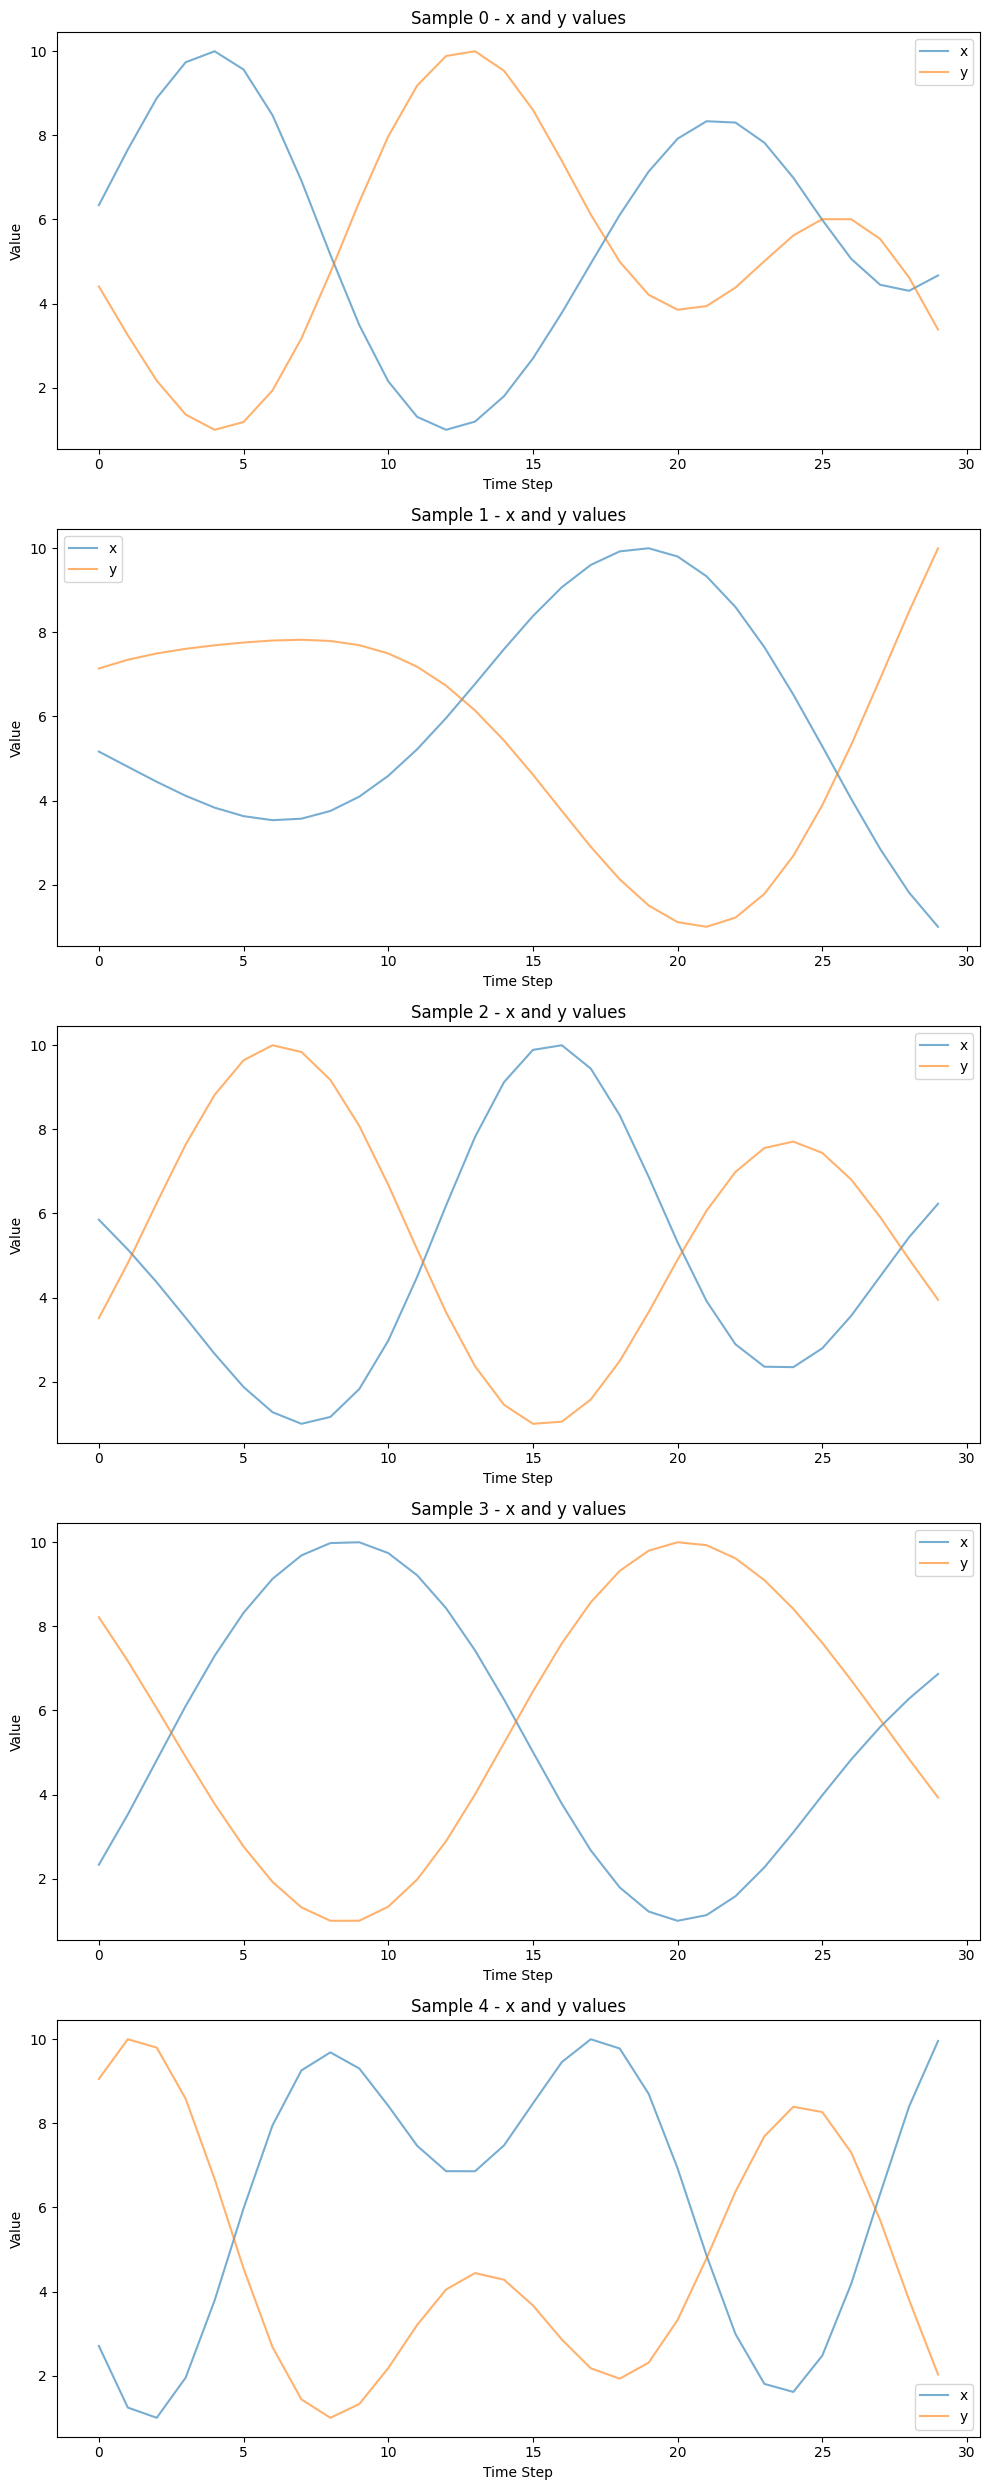

In [9]:
def plot_dataset_samples_scatter(dataloader, num_samples=5):
    """
    Plots the x and y values from the dataset for a few samples as scatter plots.
    
    Parameters:
    dataloader (DataLoader): The DataLoader containing the dataset.
    num_samples (int): Number of samples to plot.
    """
    fig, axs = plt.subplots(num_samples, 1, figsize=(10, num_samples * 5))
    
    for i, (omega0, omega1, x, y) in enumerate(dataloader):
        if i >= num_samples:
            break
        
        # Convert tensors to numpy for plotting
        x_seq = x[i, 0].detach().cpu().numpy()
        y_seq = y[i, 0].detach().cpu().numpy()

        # Scatter plot of x and y values
        axs[i].plot(range(len(x_seq)), x_seq, label='x', alpha=0.6)
        axs[i].plot(range(len(y_seq)), y_seq, label='y', alpha=0.6)
        axs[i].set_title(f'Sample {i} - x and y values')
        axs[i].set_xlabel('Time Step')
        axs[i].set_ylabel('Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Assuming dataloader is already defined
plot_dataset_samples_scatter(dataloader)

In [10]:
# Define Network
class RSNN(nn.Module):
    def __init__(self):
        super().__init__()
        # layer parameters
        num_inputs = 2
        num_hidden = 1000 # I change this to 256 *256 for control experiments
        self.num_hidden = num_hidden
        num_output = 2
        beta = 0.9
        pe_e = 0.16

        # Dictionary with probabilities of connection between each neuron type 
        p_nn = {'e_e': 0.16, 'e_PV': 0.395, 'e_Sst': 0.182, 'e_Htr': 0.105,
                'PV_e': 0.411, 'PV_PV': 0.451, 'PV_Sst': 0.03, 'PV_Htr': 0.22,
                'Sst_e': 0.424, 'Sst_PV': 0.857, 'Sst_Sst': 0.082, 'Sst_Htr': 0.77,
                'Htr_e': 0.087, 'Htr_PV': 0.02, 'Htr_Sst': 0.0625, 'Htr_Htr': 0.028 } 

        # Define the dimensions
        num_excitatory = round(0.85 * num_hidden) # 85% : 15% Excitatory to inhibitory
        self.num_excitatory = num_excitatory
        num_inhibitory = num_hidden - num_excitatory

        # Three inhibitory neuron classes: 40% PV, 30% Sst, 30% Ht3aR
        num_iPV = round(0.4 * num_inhibitory)
        num_iSst = round(0.3 * num_inhibitory)
        num_iHtr = num_inhibitory - num_iSst - num_iPV

        # Three beta values for E, PV, Sst, and Htr3aR
        # Values chosen based on spike triggered adaptation behavior of each class
        beta_e = torch.asarray([0.85] * num_excitatory)
        beta_iPV = torch.asarray([0.7] * num_iPV)   # Little/ no spike frequency adaptation 
        beta_iHtr = torch.asarray([0.6] * num_iHtr)    # Mostly adapting
        beta_iSst = torch.asarray([0.3] * num_iSst)  # Spike frequency adaptation
        beta = torch.cat((beta_e, beta_iPV, beta_iSst, beta_iHtr)) # create array of betas corresponding to each neuron!

        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        input_hid_mx = input_hid_mx
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        self.l1.weight.data = input_hid_mx.T

        # Recurrent layer weight matrix
        hidden_mx = hid_mx(num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr, p_nn) 
        hidden_mx = hidden_mx  # modification to improve asynchronous spiking 
        self.rlif1 = RLIF1(reset_mechanism='zero', beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T

        #hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.l2.weight.data = hid_out_mx.T


    def forward(self, omega0, omega1):
        inputs = torch.cat((omega0, omega1), dim=1).float()  # Concatenate along the feature dimension
        inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, num_inputs)
  
        spk1, mem1 = self.rlif1.init_rleaky()
        
        # Record outputs
        self.spk1_rec = []
        self.cur2_rec = []
        
        for step in range(inputs.shape[0]): #100
            cur_input = inputs[step,:]
            # cur_input = inputs[step]
            cur1 = self.l1(cur_input)
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)

        self.spk1_rec = torch.stack(self.spk1_rec)
        self.cur2_rec = torch.stack(self.cur2_rec)

        pred_x = self.cur2_rec[:,:,0].unsqueeze(1) #Make sure the pred_x same shape as actual_x
        pred_y = self.cur2_rec[:,:,1].unsqueeze(1) #Make sure the pred_y same shape as actual_y

        return pred_x, pred_y, self.spk1_rec

    
    def positive_negative_weights(self):
        
        excitatory_weights = self.rlif1.recurrent.weight.data[:, :self.num_excitatory]
        inhibitory_weights = self.rlif1.recurrent.weight.data[:, self.num_excitatory:]

        #save the number of positives in inhibitory and negatives in excitatory region
        num_false_neg = torch.sum(excitatory_weights < 0).item()
        num_false_pos = torch.sum(inhibitory_weights > 0).item()

        self.false_neg.append(num_false_neg) 
        self.false_pos.append(num_false_pos) 

        # Clamp switched sign values at 0
        excitatory_weights.clamp_(min=0)
        inhibitory_weights.clamp_(max=0)

        mu = -0.64
        sigma = 0.51

        #following code picks random indices from excitatory and inhibitory originating weights
        #for the number of num_false_neg and num_false_neg for inhibitory and excitatory originating weights respectively
        #assigns them with the lognormal dist
        excitatory_zero_indices = (self.rlif1.recurrent.weight.data[:, :self.num_excitatory] == 0).nonzero(as_tuple=True)
        inhibitory_zero_indices = (self.rlif1.recurrent.weight.data[:, self.num_excitatory:] == 0).nonzero(as_tuple=True)

        if (len(excitatory_zero_indices) > num_false_pos):
            excitatory_sampled_indices = torch.stack([
                    excitatory_zero_indices[0][torch.randint(len(excitatory_zero_indices[0]), (num_false_pos,))],
                    excitatory_zero_indices[1][torch.randint(len(excitatory_zero_indices[1]), (num_false_pos,))]
                ], dim=1)

            # generating self.excitatory_changes number of lognormal values
            new_excitatory_values = torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_pos)).float()
            self.rlif1.recurrent.weight.data[excitatory_sampled_indices[:, 0], excitatory_sampled_indices[:, 1]] = new_excitatory_values

        if (len(inhibitory_zero_indices) > num_false_neg):
            inhibitory_sampled_indices = torch.stack([
                    inhibitory_zero_indices[0][torch.randint(len(inhibitory_zero_indices[0]), (num_false_neg,))],
                    inhibitory_zero_indices[1][torch.randint(len(inhibitory_zero_indices[1]), (num_false_neg,))]
                ], dim=1)

            new_inhibitory_values = -torch.from_numpy(np.random.lognormal(mean=mu, sigma=sigma, size=num_false_neg)).float()
            self.rlif1.recurrent.weight.data[inhibitory_sampled_indices[:, 0], self.num_excitatory + inhibitory_sampled_indices[:, 1]] = new_inhibitory_values

In [11]:
def plot_sample_convergence(epoch, pred_x, pred_y, actual_x, actual_y, sample_idx, stage): # Plot x&y samples from the dataset
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Flatten the tensors to compare the entire sequence
    actual_x_seq = actual_x[sample_idx].detach().cpu().numpy()
    pred_x_seq = pred_x[sample_idx].flatten().detach().cpu().numpy()
    actual_y_seq = actual_y[sample_idx].detach().cpu().numpy()
    pred_y_seq = pred_y[sample_idx].flatten().detach().cpu().numpy()

    # Plot x convergence
    axs[0].plot(range(len(actual_x_seq)), actual_x_seq, label='Actual x', alpha=0.6)
    axs[0].plot(range(len(pred_x_seq)), pred_x_seq, label='Predicted x', alpha=0.6)
    axs[0].set_title(f'{stage} - x Convergence (Epoch {epoch+1})')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('Value')
    axs[0].legend()

    # Plot y convergence
    axs[1].plot(range(len(actual_y_seq)), actual_y_seq, label='Actual y', alpha=0.6)
    axs[1].plot(range(len(pred_y_seq)), pred_y_seq, label='Predicted y', alpha=0.6)
    axs[1].set_title(f'{stage} - y Convergence (Epoch {epoch+1})')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Value')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [12]:
class CustomLoss(nn.Module): # Only firing rate loss and task loss is concerned

    def __init__(self, target_firing_rate=0.02, batch_size=50):
        super(CustomLoss, self).__init__()
        self.target_firing_rate = torch.tensor([target_firing_rate] * batch_size,requires_grad=True)

    def forward(self, pred_x, pred_y, actual_x, actual_y, firing_rate):

        w_rate = 0
        w_mse = 1
        
        mse_loss = nn.MSELoss()(pred_x, actual_x) + nn.MSELoss()(pred_y, actual_y)
        rate_loss = nn.MSELoss()(firing_rate, self.target_firing_rate)
       
        self.mse_loss = mse_loss
        self.rate_loss = rate_loss

        total_loss = w_mse*mse_loss + w_rate*rate_loss 

        return total_loss

In [13]:
def create_dir(directory):
    if not os.path.exists(directory): # Create directory on local devices for storing data
        os.makedirs(directory)

create_dir('results')

In [14]:
model = RSNN()
criterion = CustomLoss(target_firing_rate=0.02)
# for param in model.rlif1.recurrent.parameters():
#     param.requires_grad = False
# for param in model.l1.parameters():          # Manually set gradients to not change during training for specific layer
#     param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.005) # To filter out the parameters not requiring gradients

num_epochs = 200
sample_idx = 0 #for ploting 
stored_predictions = {'beginning': None, 'middle': None, 'end': None} # for plotting trajectories
epoch_loss = []

# Sparsity
weights = model.rlif1.recurrent.weight.data
sparsity_list = []
zero_idxs = torch.where(weights == 0, 1, 0)  # Create a matrix to identify where zeroes are initialized in weight matrix

loss_list = []
synch_list = []
rate_list = []
crit_list = []

epoch_input_gradients = []
epoch_rec_grads =[]
epoch_output_grads =[]

epoch_input_weights =[]
epoch_output_weights =[]
epoch_recurrent_weights =[]

#store information in numpy arrays and then save to npy files
os.makedirs('epoch_data', exist_ok=True)
# one file per epoch in the folder called 'epoch_data'

for epoch in range(num_epochs):
    epoch_spikes = []
    epoch_losses = []
    epoch_firing_rates = []
    epoch_inputs = []
    epoch_outputs = []
    epoch_expected = []
    running_loss = 0
    
    batch_spikes = []
    batch_input_weights = []
    batch_recurrent_weights = []
    batch_output_weights = []
    batch_losses = []
    batch_inputs = []
    batch_outputs = []
    batch_expected = []
    batch_gradients = []
    batch_input_gradients = []
    batch_rec_gradients =[]
    batch_output_gradients =[]

    for batch_idx, (omega0, omega1, actual_x, actual_y) in enumerate(dataloader):
        optimizer.zero_grad()

        firing_rate_per_batch = torch.empty(0,dtype=torch.float32, requires_grad=True)
        omega0, omega1, actual_x, actual_y = omega0.float(), omega1.float(), actual_x.float(), actual_y.float()  # Convert to Float
        pred_x, pred_y, spikes = model(omega0, omega1)
        trial_spikes = []

        for trials in range(n_batch):
            concat_inputs= torch.cat((omega0[trials].squeeze(1), omega1[trials].squeeze(1)),dim=1)
            batch_inputs.append(concat_inputs)
            concat_expected =torch.cat((actual_x[trials].squeeze(1), actual_y[trials].squeeze(1)),dim=1)
            batch_expected.append(concat_expected)
            concat_outputs = torch.cat((pred_x[trials].squeeze(1), pred_y[trials].squeeze(1)),dim=1)
            batch_outputs.append(concat_outputs)
    
            single_trial_spikes = spikes[trials]
            trial_spikes.append(spikes.squeeze().detach().cpu().numpy())

            # firing rate
            firing_rate = torch.sum(single_trial_spikes)/torch.tensor(30000, dtype=torch.int) # 30 * 1000    
            firing_rate = firing_rate.reshape([1])
            firing_rate_per_batch = torch.cat((firing_rate_per_batch,firing_rate))

            
        batch_spikes.append(spikes.detach().cpu().numpy())
        avg_firing_rate = float(torch.sum(firing_rate_per_batch)/50)
        print('avg firing rate per batch:', avg_firing_rate)  

        loss = criterion(pred_x, pred_y, actual_x, actual_y, firing_rate_per_batch)
        running_loss += loss.item()
    
        loss.backward()
        # Saving gradients
        batch_input_gradients.append(model.l1.weight.grad.detach().cpu().numpy())
        batch_rec_gradients.append(model.rlif1.recurrent.weight.grad.detach().cpu().numpy())
        batch_output_gradients.append(model.l2.weight.grad.detach().cpu().numpy())

        optimizer.step()
        batch_losses.append(loss.item())

        batch_input_weights.append(model.l1.weight.data.clone().detach().cpu().numpy())
        batch_recurrent_weights.append(model.rlif1.recurrent.weight.data.clone().detach().cpu().numpy())
        batch_output_weights.append(model.l2.weight.data.clone().detach().cpu().numpy())

        # Enforce sparsity by zeroing any weights that were initialized to zero
        weights[zero_idxs==True] = 0
        sparsity = (weights.numel() - weights.count_nonzero()) / weights.numel()  # Calculate sparsity 
        sparsity_list.append(sparsity)

        model.positive_negative_weights()

    # Print epoch loss
    avg_epoch_loss = running_loss / len(dataloader)
    mse_epoch_loss = criterion.mse_loss / len(dataloader)
    rate_epoch_loss = criterion.rate_loss / len(dataloader)
    
    epoch_firing_rates.extend(firing_rate_per_batch.detach().numpy())
    epoch_inputs.extend([x.detach().cpu().numpy() for x in batch_inputs])
    epoch_outputs.extend([x.detach().cpu().numpy() for x in batch_outputs])
    epoch_expected.extend([x.detach().cpu().numpy() for x in batch_expected])
    epoch_input_gradients.append(batch_input_gradients)
    epoch_rec_grads.append(batch_rec_gradients)
    epoch_output_grads.append(batch_output_gradients)
    epoch_spikes.append(batch_spikes)

    np.savez_compressed(f'epoch_data/epoch_{epoch + 1}.npz',  # Storing all the data as npz file
                        input_weights=np.array(epoch_input_weights),
                        rec_weights=np.array(epoch_recurrent_weights),
                        output_weights=np.array(epoch_output_weights),
                        spikes=np.array(batch_spikes),
                        losses=np.array(epoch_losses),
                        firing_rates=np.array(epoch_firing_rates),
                        inputs=np.array(epoch_inputs),
                        outputs=np.array(epoch_outputs),
                        expected=np.array(epoch_expected),
                        input_gradients = np.array(epoch_input_gradients),
                        reccurent_gradients = np.array(epoch_rec_grads),
                        output_gradients = np.array(epoch_output_grads))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")
   
# Plot convergence for the sample at the beginning, intermediate, and end of training
    if epoch == 1:
        stored_predictions['beginning'] = (pred_x[sample_idx].detach().cpu().numpy(), pred_y[sample_idx].detach().cpu().numpy())
    elif epoch == num_epochs // 2:
        stored_predictions['middle'] = (pred_x[sample_idx].detach().cpu().numpy(), pred_y[sample_idx].detach().cpu().numpy())
    elif epoch == num_epochs - 1:
        stored_predictions['end'] = (pred_x[sample_idx].detach().cpu().numpy(), pred_y[sample_idx].detach().cpu().numpy())

# Store final weights
final_weights = model.l2.weight.data.clone()
# final_weights = model.state_dict()
actual_x_seq = actual_x.squeeze()[sample_idx].detach().cpu().numpy()
actual_y_seq = actual_y.squeeze()[sample_idx].detach().cpu().numpy()



batch_idx 0


/var/folders/_5/77pml32s01b27rqdn8pjj4xh0000gp/T/ipykernel_62754/2692229609.py:85: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  criticality = simple_branching_param(1, spikes.T)


avg firing rate per batch: 0.019438667222857475
batch_idx 1
avg firing rate per batch: 0.018858667463064194
batch_idx 2
avg firing rate per batch: 0.01893933117389679
batch_idx 3
avg firing rate per batch: 0.019240666180849075
batch_idx 4
avg firing rate per batch: 0.01937600038945675
batch_idx 5
avg firing rate per batch: 0.01929866522550583
batch_idx 6
avg firing rate per batch: 0.020201999694108963
batch_idx 7
avg firing rate per batch: 0.020213333889842033
batch_idx 8
avg firing rate per batch: 0.01886799931526184
batch_idx 9
avg firing rate per batch: 0.019444666802883148
batch_idx 10
avg firing rate per batch: 0.019470667466521263
batch_idx 11
avg firing rate per batch: 0.019686667248606682
batch_idx 12
avg firing rate per batch: 0.019087333232164383
batch_idx 13
avg firing rate per batch: 0.01927933283150196
batch_idx 14
avg firing rate per batch: 0.018906667828559875
batch_idx 15
avg firing rate per batch: 0.019270000979304314
batch_idx 16
avg firing rate per batch: 0.018426666

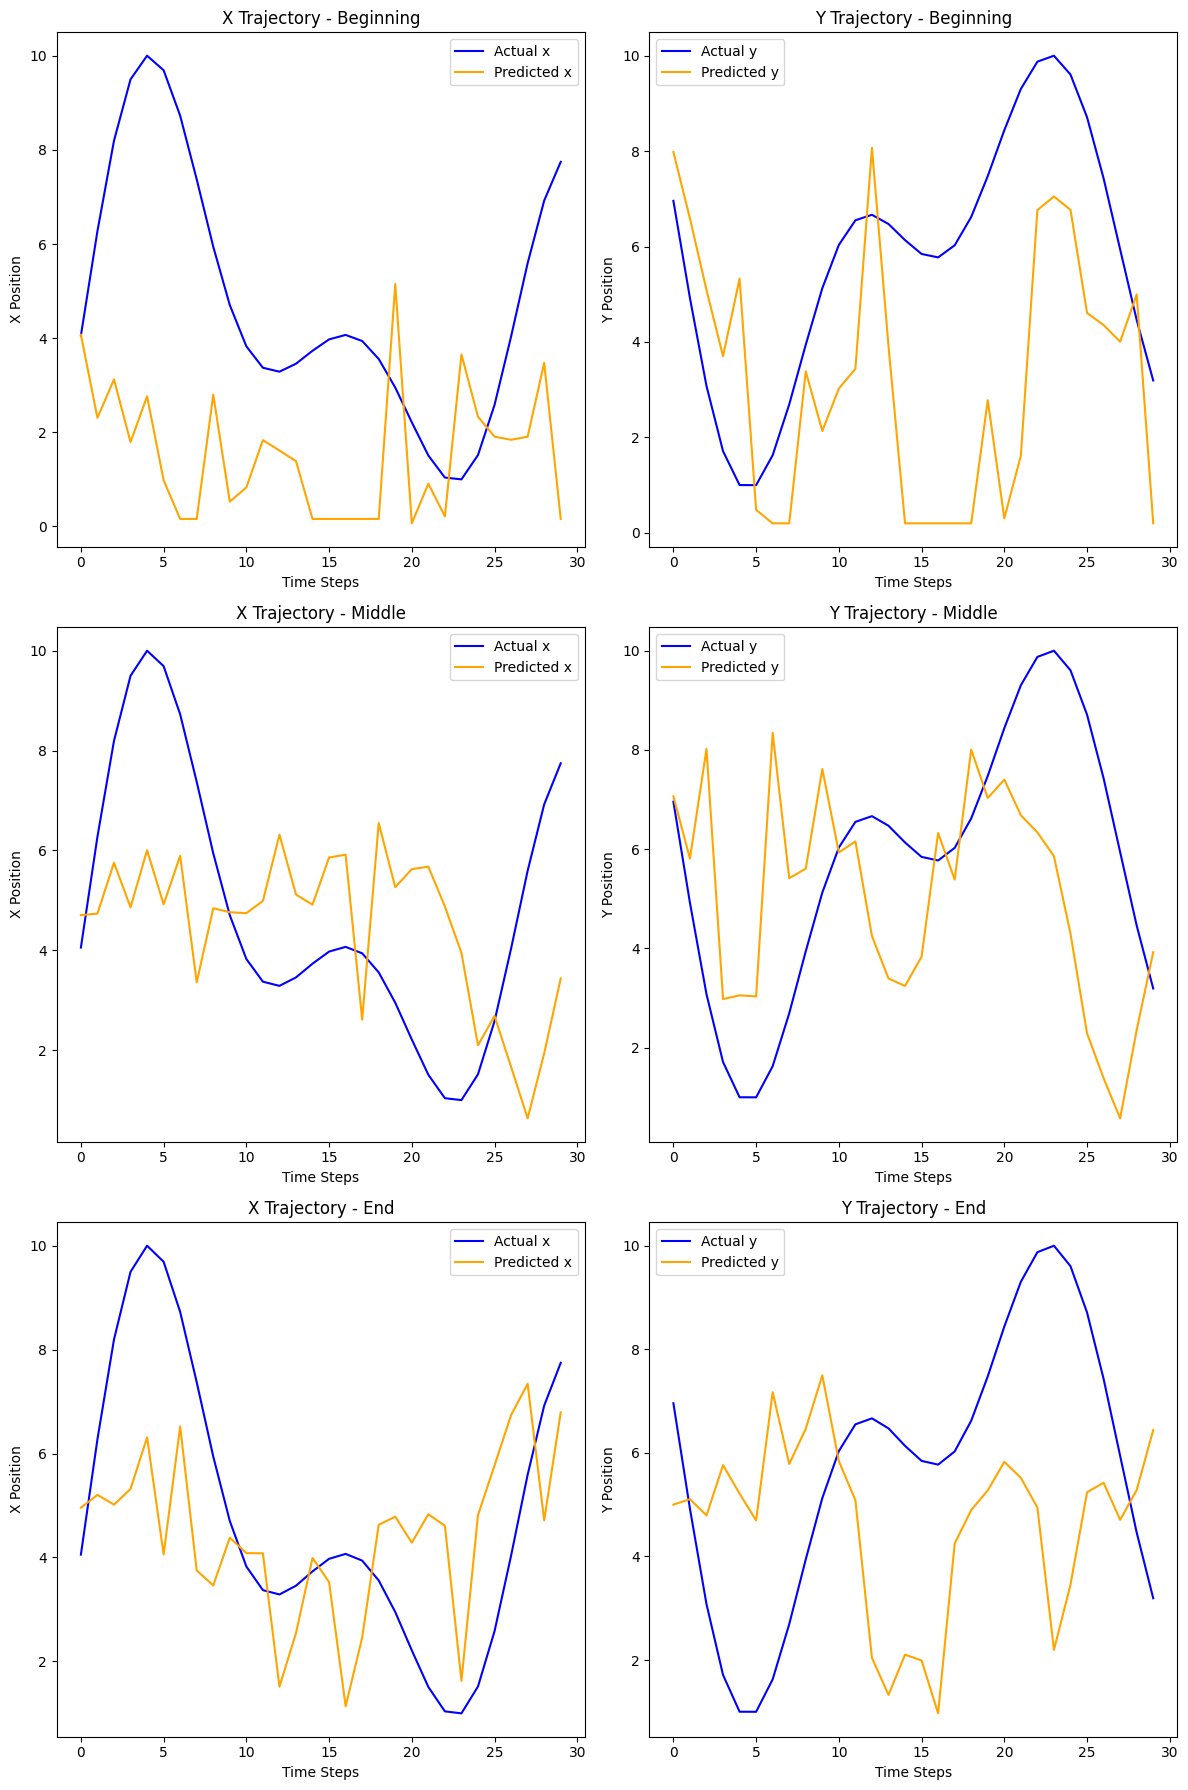

In [20]:
def plot_trajectories(stored_predictions, actual_x, actual_y):
    stages = ['beginning', 'middle', 'end']
    fig, axs = plt.subplots(3, 2, figsize=(12, 18))

    for i, stage in enumerate(stages):
        pred_x, pred_y = stored_predictions[stage]

        # Plot x trajectory
        axs[i, 0].plot(range(seq_length), actual_x.flatten(), label='Actual x', color='blue')
        axs[i, 0].plot(range(seq_length), pred_x.flatten(), label='Predicted x', color='orange')
        axs[i, 0].set_title(f'X Trajectory - {stage.capitalize()}')
        axs[i, 0].set_xlabel('Time Steps')
        axs[i, 0].set_ylabel('X Position')
        axs[i, 0].legend()

        # Plot y trajectory
        axs[i, 1].plot(range(seq_length), actual_y.flatten(), label='Actual y', color='blue')
        axs[i, 1].plot(range(seq_length), pred_y.flatten(), label='Predicted y', color='orange')
        axs[i, 1].set_title(f'Y Trajectory - {stage.capitalize()}')
        axs[i, 1].set_xlabel('Time Steps')
        axs[i, 1].set_ylabel('Y Position')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Plot the trajectories for X, Y 
plot_trajectories(stored_predictions, actual_x_seq, actual_y_seq)

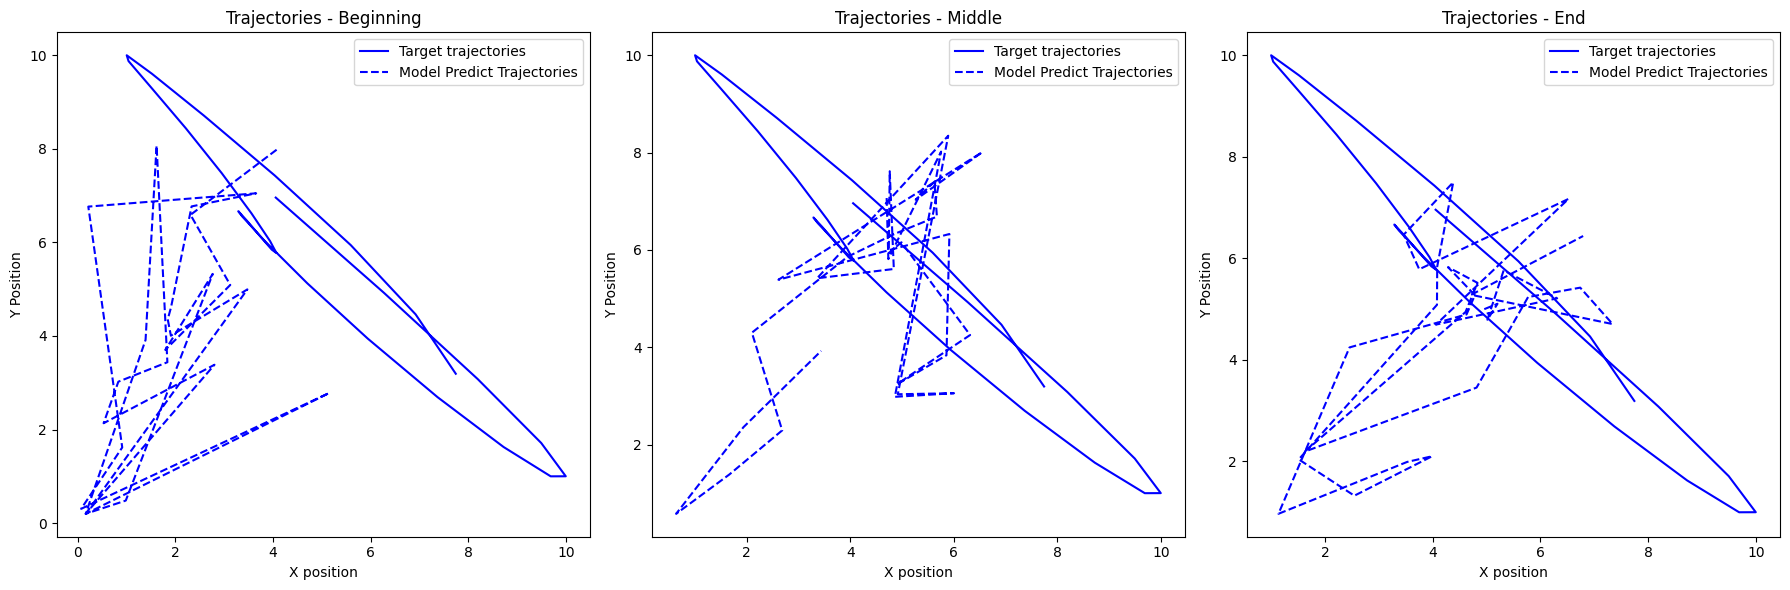

In [16]:
def plot_trajectories(stored_predictions, actual_x, actual_y):
    stages = ['beginning', 'middle', 'end']
    fig, axs = plt.subplots(1, len(stages), figsize=(18, 6))

    for i, stage in enumerate(stages):
        pred_x, pred_y = stored_predictions[stage]
        target_x = actual_x
        target_y = actual_y
        # Plot xy trajectory in 2D
        axs[i].plot(target_x.flatten(),target_y.flatten(),label='Target trajectories', color='blue')
        axs[i].plot(pred_x.flatten(), pred_y.flatten(),label = 'Model Predict Trajectories', linestyle='dashed', color = 'blue')
        axs[i].set_title(f'Trajectories - {stage.capitalize()}')
        axs[i].set_xlabel('X position')
        axs[i].set_ylabel('Y Position')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Plot the trajectories (x,y together)
plot_trajectories(stored_predictions, actual_x_seq, actual_y_seq)

In [17]:
def load_epoch_data(epoch): # Load saved data from files on local directory
    file_path = f'epoch_data/epoch_{epoch}.npz'
    data = np.load(file_path, allow_pickle=True)
    return data

Ze_data = load_epoch_data(1) # epoch at the beginning of the training
Fe_data = load_epoch_data(199) # epoch close to the end of the training
print(Ze_data.files) # Items saved in the directory

['weights', 'spikes', 'losses', 'firing_rates', 'inputs', 'outputs', 'expected', 'input_gradients', 'reccurent_gradients', 'output_gradients']


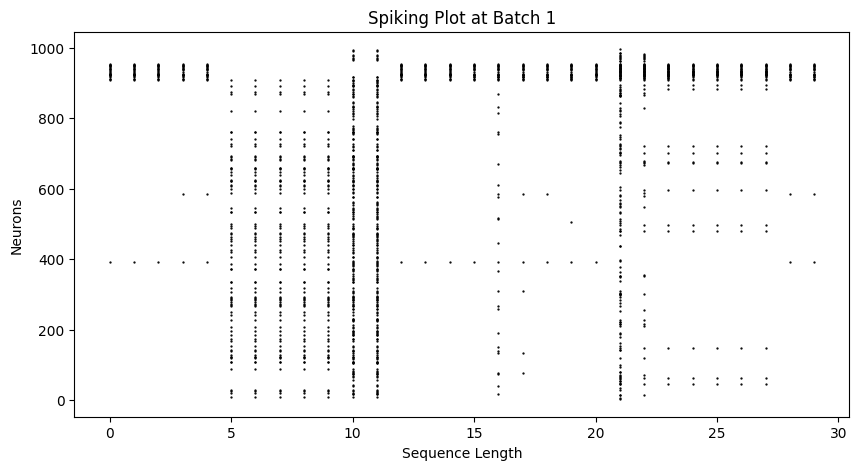

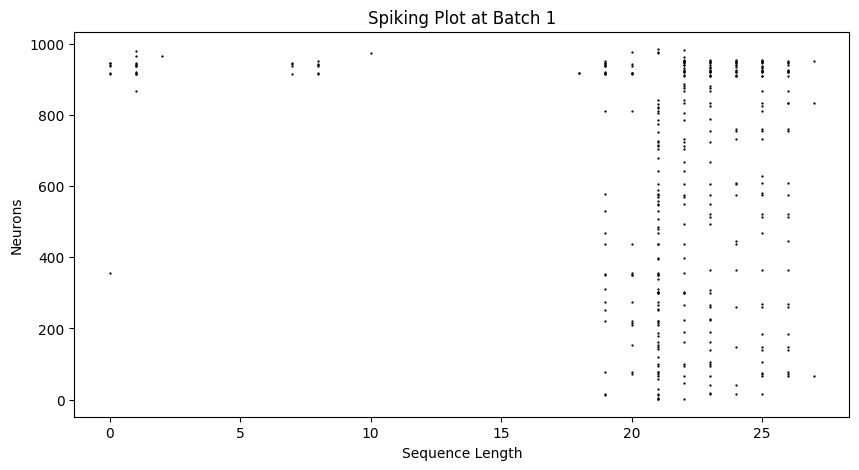

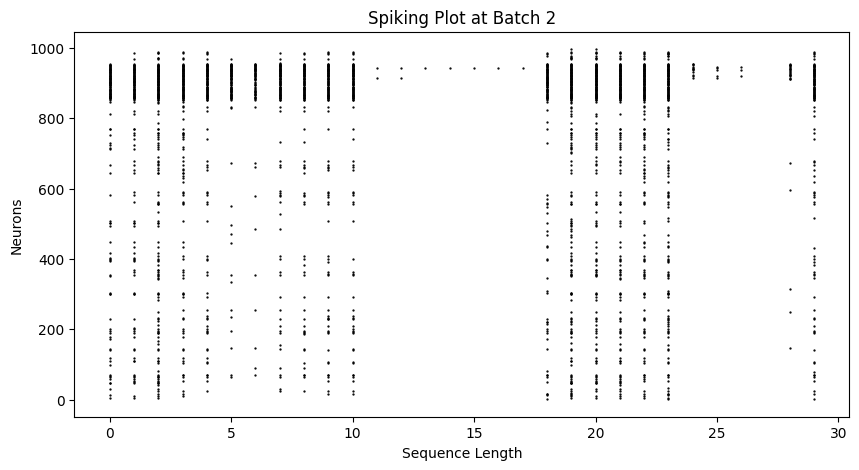

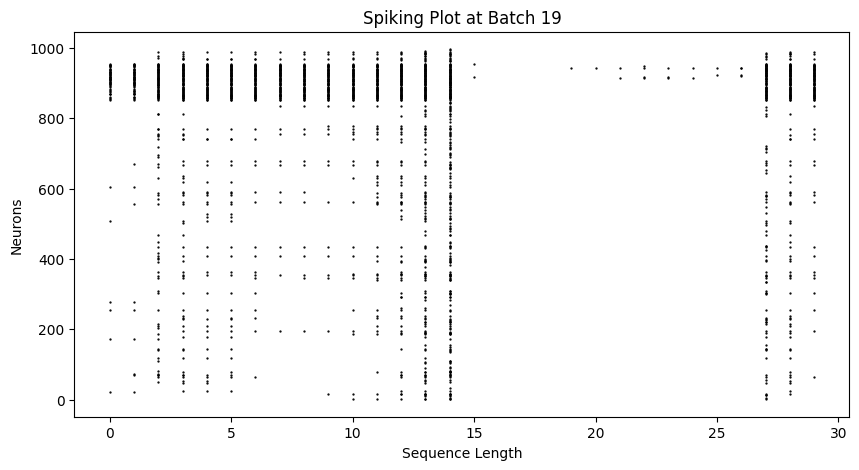

In [ ]:
def plot_spike_tensor(spk_tensor, title):
    # Generate the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    splt.raster(spk_tensor.T, ax=ax, s=0.4, c="black")  # Transpose to align with neurons on y-axis

    # Set labels and title
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Sequence Length")
    ax.set_title(title)

    plt.show()

spikes_torch = torch.from_numpy(Ze_data['spikes']) 
plot_spike_tensor(spikes_torch[0][1,:,:].T, 'Spiking Plot at Batch 1') # spikes_torch shape (20,50,32,1000) which is (iterations of batch in each epoch, batch_size, sequence_len, neurons)
plot_spike_tensor(spikes_torch[0][9,:,:].T, 'Spiking Plot at Batch 1')
plot_spike_tensor(spikes_torch[8][1,:,:].T, 'Spiking Plot at Batch 2')
plot_spike_tensor(spikes_torch[19][1,:,:].T, 'Spiking Plot at Batch 19')

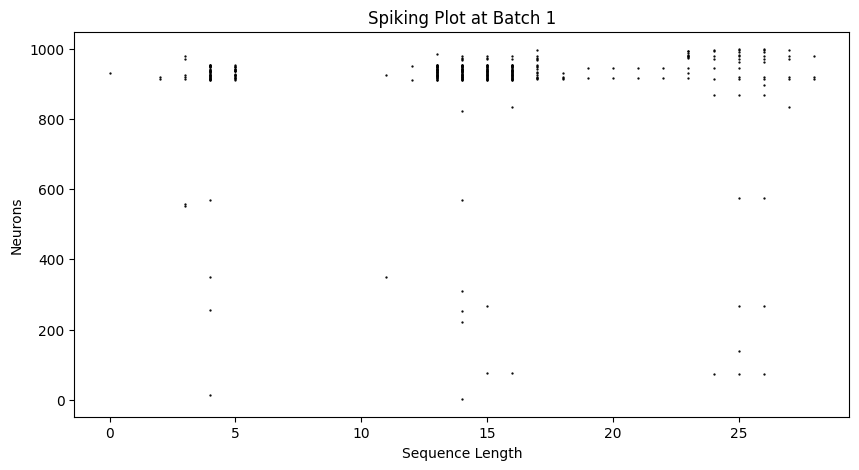

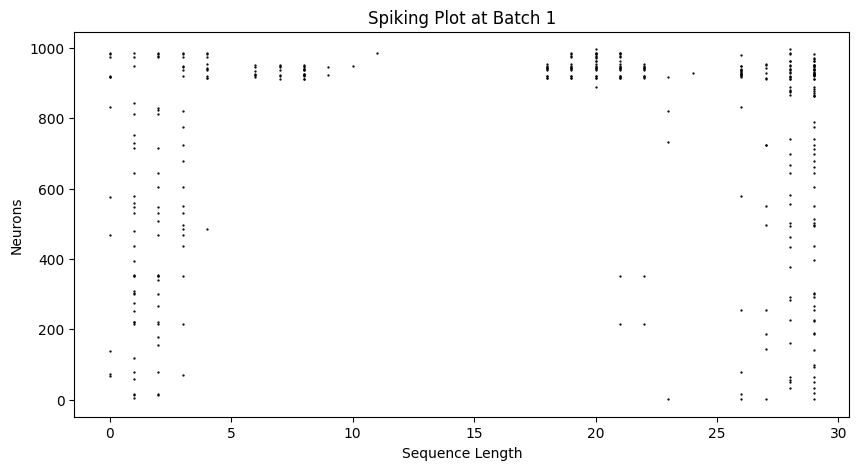

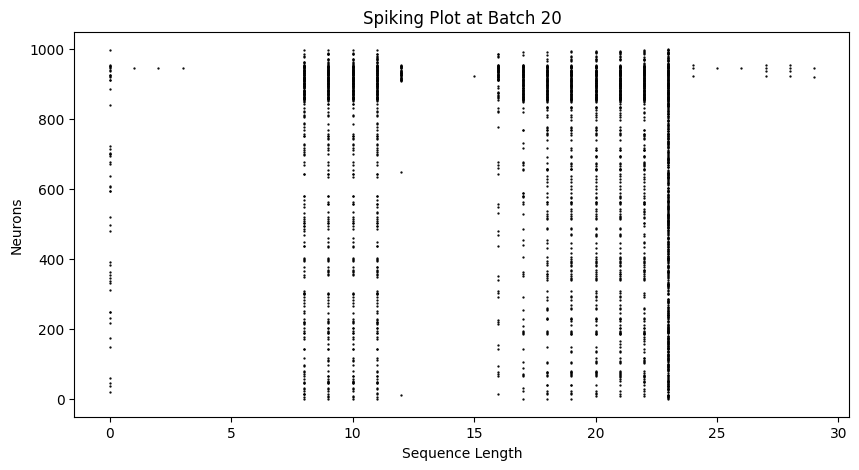

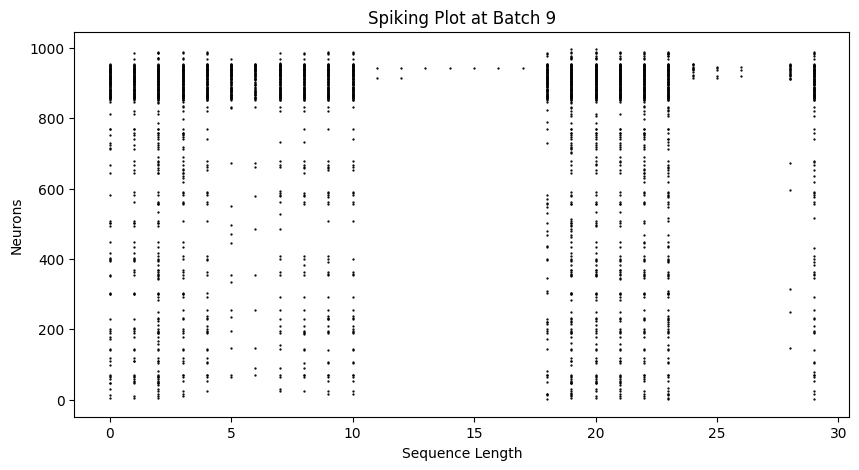

In [ ]:
spikes_torch = torch.from_numpy(Fe_data['spikes']) 
plot_spike_tensor(spikes_torch[6][25,:,:].T, 'Spiking Plot at Batch 1')
plot_spike_tensor(spikes_torch[0][49,:,:].T, 'Spiking Plot at Batch 1')
plot_spike_tensor(spikes_torch[2][1,:,:].T, 'Spiking Plot at Batch 20')
plot_spike_tensor(spikes_torch[8][1,:,:].T, 'Spiking Plot at Batch 9')

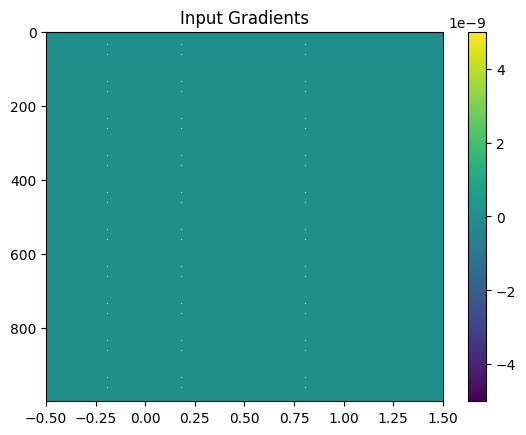

In [ ]:
Input_grads_change = Fe_data['input_gradients'][0][1]

plt.title('Input Gradients')
plt.imshow(Input_grads_change,aspect='auto', cmap='viridis', vmin= -0.000000005, vmax=0.000000005)
plt.colorbar()

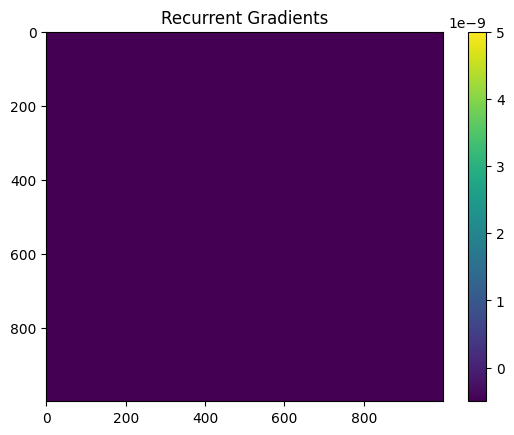

In [ ]:
Rec_grads_change = Fe_data['reccurent_gradients'][0][1]

plt.title('Recurrent Gradients')
plt.imshow(Rec_grads_change,aspect='auto', cmap='viridis', vmin= -0.0000000005, vmax=0.000000005)
plt.colorbar()

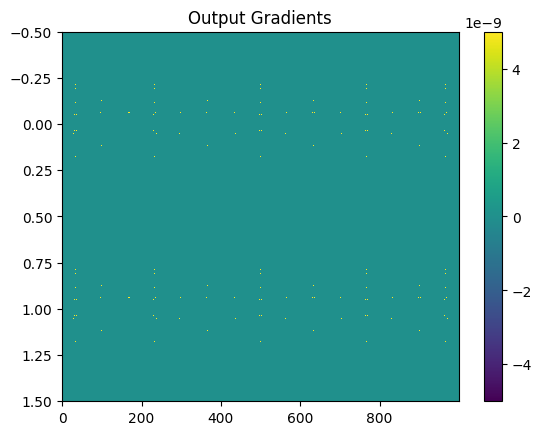

In [ ]:
Out_grads_change = Fe_data['output_gradients'][0][1]

plt.title('Output Gradients')
plt.imshow(Out_grads_change,aspect='auto', cmap='viridis', vmin= -0.000000005, vmax=0.000000005)
plt.colorbar()

In [ ]:
# Plot weight changes for each layer

Input_weight_changes = Fe_data['input_weights'][0][1]-Ze_data['input_weights'][0][1]
plt.title('Input Layer Weight Change')
plt.imshow(Input_weight_changes,aspect='auto', cmap='viridis', vmin= -10, vmax=10)
plt.colorbar()

Recurrent_weight_changes = Fe_data['rec_weights'][0][1]-Ze_data['rec_weights'][0][1]
plt.title('Recurrent Layer Weight Change')
plt.imshow(Recurrent_weight_changes,aspect='auto', cmap='viridis', vmin= -10, vmax=10)
plt.colorbar()

Output_weight_changes = Fe_data['output_weights'][0][1]-Ze_data['output_weights'][0][1]
plt.title('Output Layer Weight Change')
plt.imshow(Output_weight_changes,aspect='auto', cmap='viridis', vmin= -10, vmax=10)
plt.colorbar()